In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d #unsure if needed

# suppress scientific notation for now
np.set_printoptions(suppress=True)
pd.options.display.float_format = '{:.4f}'.format
#%matplotlib notebook
# makes it way slower

## To Do:
1. Change to only record every ith timestep - done
2. Change to match initial conditions given in Jaeger
3. Compare to Jaeger results for different d-values
4. Check population remains constant when only drift/diffusion switched on - done (minor errors)
6. Look at other depths
5. Look at how shifts in light affect stationary distribution


[Cython info](https://ipython-books.github.io/55-accelerating-python-code-with-cython/)

In [ ]:
def get_stationary(zmax,tmax,d,I0):

In [2]:
# define default coefficients
v= 0.25    # drift term
lbg=0.1    # Specific algal maintenance respiration losses
mumax=1.2  # Maximum specific algal production rate
rhomax=0.2 # Maximum specific algal nutrient uptake rate
qmax=0.04  # Maximum algal nutrient quota
qmin=0.004 # Minimum algal nutrient quota 
m=1.5      # Half-saturation constant of algal nutrient uptake
h=120.0    # Half-saturation constant of light-dependent algal production
I0 = 300   # Light intensity at the surface 
kbg=0.4    # Background light-attenuation coefficient 

def rnorm(mu,sigma,z):
    """create normal hump around mu over z, of std. dev. sigma"""
    return np.exp( -(z-mu)**2/(2*sigma**2) )/ np.sqrt(2*np.pi*sigma**2)

def I(z,A,I_0=I0,k = 0.0003):
    """Function to plot I using array A[:,i], default k=0.0003, larger values of k make effect of A on I more apparent"""
    integral = np.zeros(len(z))
    integral[1:] = np.cumsum(k*A[1:]) 
    return I_0 * np.exp( -integral - kbg*z)

def p(I,q):
    return mumax * (1.0 - qmin/q) * (I/(h + I))

def rho(q, Rd):
    return rhomax * (qmax-q)/(qmax-qmin) * ( Rd/(m + Rd) )

In [3]:
def next_step(z,A, Rd, Rb):
    """Calculates next step for input arrays of length zmax"""
    
    II = I(z,A)
    q = Rb[1:-1]/A[1:-1]
    pp = p(II[1:-1],q)
    rrho = rho(q,Rd[1:-1])
    
    A_next = np.zeros(len(A))
    Rb_next = np.zeros(len(Rb))
    Rd_next = np.zeros(len(Rd))
    
    A_drift = v * (A[2:]-A[:-2]) / (2*dz)
    A_diffusion = d * (A[2:]-2*A[1:-1] + A[:-2]) / (dz**2)
    Rb_drift = v * (Rb[2:]-Rb[:-2]) / (2*dz)
    Rb_diffusion = d * (Rb[2:]-2*Rb[1:-1] + Rb[:-2]) / (dz**2)
    Rd_diffusion = d * (Rd[2:]-2*Rd[1:-1] + Rd[:-2]) / (dz**2)
    
    A_next[1:-1] = A[1:-1] + dt * ( pp*A[1:-1] -lbg*A[1:-1] - A_drift + A_diffusion )
    A_next[0] = 4*d/(2*v*dz + 3*d)*A_next[1] - d/(2*v*dz + 3*d)*A_next[2] 
    A_next[-1] = (4*A_next[-2] - A_next[-3])/3
    
    Rb_next[1:-1] = Rb[1:-1] + dt * (rrho*A[1:-1] -lbg*Rb[1:-1] - Rb_drift + Rb_diffusion )
    Rb_next[0] = 4*d/(2*v*dz + 3*d)*Rb_next[1] - d/(2*v*dz + 3*d)*Rb_next[2] 
    Rb_next[-1] = (4*Rb_next[-2] - Rb_next[-3])/3
    
    Rd_next[1:-1] = Rd[1:-1] + dt*(lbg*Rb[1:-1] -rrho*A[1:-1] + Rd_diffusion)
    Rd_next[0] = (4*Rd_next[1] - Rd_next[2])/3 
    Rd_next[-1] = ( 4*d*Rd_next[-1] - d*Rd_next[-2] + v*dz*Rb_next[-1] ) / (3*d)
    
    return A_next, Rd_next, Rb_next

In [4]:
zmax = 30.0 # meters
tmax = 100.0 # days
dz = 0.1
dt = dz/1000 # temporary 
Nz = int(zmax/dz)
Nt = int(tmax/ (1000*dt) )

z_grid = np.arange(0,zmax,dz)
time_steps = np.arange(0,tmax,dt)

peak_location = zmax/4.0

A_0 = 100 # scales the hump
A = np.zeros((Nz,Nt)) # RESULTS MATRIX: rows: deeper z-values, cols: time steps forward
#A[:,0] = A_0 * rnorm(peak_location,1,z_grid) # creates intitial hump
A[:,0] = A_0 * np.ones(Nz) # creates homogenous initial conditions

Rb_0 = 2.2
Rb = np.zeros((Nz,Nt))
#Rb[:,0] = Rb_0 * rnorm(peak_location,1,z_grid)
Rb[:,0] = Rb_0 * np.ones(Nz)

Rd_0 = 30 # scales the hump
Rd = np.zeros((Nz,Nt))
#Rd[:,0] = Rd_0 * rnorm(peak_location,1,z_grid)
Rd[:,0] = Rd_0 * np.ones(Nz)

In [5]:
len(time_steps[:-1])

999999

In [6]:
d = 1.0 # diffusion term

A_next,Rd_next,Rb_next = next_step(z_grid,A[:,0],Rd[:,0],Rb[:,0]) #initial conditions

i = 1
counter = 1
for t in time_steps[:-1]:
    A_next,Rd_next,Rb_next = next_step(z_grid,A_next,Rd_next,Rb_next)
    if ( i % 1000 == 0):
        A[:,counter],Rd[:,counter],Rb[:,counter] = A_next,Rd_next,Rb_next
        counter = counter +1
    i = i+1

KeyboardInterrupt: 

In [7]:
counter

897

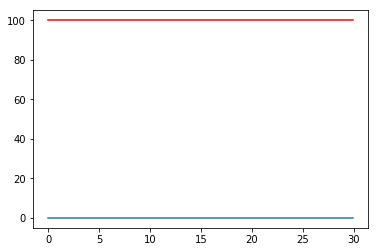

In [8]:
# Visualize Shift
plt.plot(z_grid,A[:,-1])
plt.plot(z_grid,A[:,0],color = 'r')

[link to some results for changing d-vals](https://docs.google.com/document/d/1POVHeioH5Hxn5Z6kMn3Pn7SVLBypnAmwy5iTJadKIxo/edit?usp=sharing)

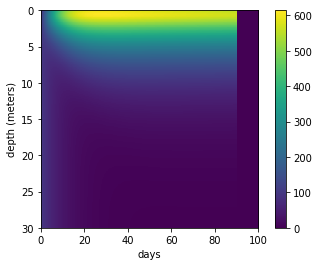

In [9]:
# Heatmap
plt.imshow(A[:,:],aspect=tmax/zmax,origin="lower",extent=(0,tmax,0,zmax))
plt.xlabel('days')
plt.ylabel('depth (meters)')
plt.gca().invert_yaxis()
plt.colorbar()

ValueError: shape mismatch: objects cannot be broadcast to a single shape

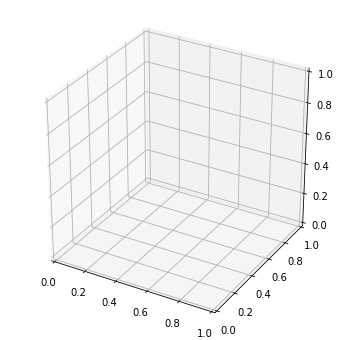

In [11]:
# 3D Visualize
#T,Z = np.meshgrid(time_steps,z_grid)
days = np.linspace(0,tmax,Nz)[:-1]
T,Z = np.meshgrid(days,z_grid[:-1])

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(T,Z, A[:-1,:-1], cmap='cool')
ax.set_xlabel('time (days)')
ax.set_ylabel('z (meters)')
ax.set_zlabel('C')
ax.set_title('A - Phytoplankton')